In [77]:
import shutil
import logging
import numpy as np
import matplotlib.pyplot as plt
from madminer.utils.interfaces.mg import (
    generate_mg_process,
    prepare_run_mg_pythia,
    run_mg_pythia,
)

In [2]:
mg_directory = '/Users/dpappadopulo/Projects/~Physics/MG5_2.6.4'
temp_directory = mg_directory + '/tmp'
cards_dir = '/Users/dpappadopulo/Projects/~Physics/madminer/examples/example1_wgamma/cards'
lhapdf_repo = "/Users/dpappadopulo/Projects/~Physics/MG5_2.6.4/HEPTools/lhapdf6/share/LHAPDF/PDF4LHC_repo"
lhapdf_dir = "/Users/dpappadopulo/Projects/~Physics/MG5_2.6.4/HEPTools/lhapdf6/share/LHAPDF/PDF4LHC15_nlo_30"


run_cards = ['run_card_{}.dat'.format(i) for i in range(18)]
dat_files = ['PDF4LHC15_nlo_30_'+'{:04d}'.format(i)+'.dat' for i in range(31)]

This set up the environment to generate the events

In [3]:
generate_mg_process(
            mg_directory,
            temp_directory, # ?
            cards_dir + '/proc_card_wgamma.dat', # where the process card is
            temp_directory , # events are gonna go in temp_directory/Events
            ufo_model_directory=None,
            log_file=temp_directory+ '/log.txt', # where to save the logs
            initial_command= None # forget about this
        )

Generate the events

In [ ]:
for bin_id in range(18):
    for pdf_id in range(31):
        print "Doing pT bin number: {}".format(bin_id) + " - PDF member number: {}".format(pdf_id)
        
        # This moves everythime the PDF card in the folder where it can be read by MG, 
        # and renames it as the central member of the PDF set.
        shutil.copy(lhapdf_repo + '/' + dat_files[pdf_id], lhapdf_dir + '/' + 'PDF4LHC15_nlo_30_0000.dat')
        
        run_mg_pythia(
                        mg_directory,
                        temp_directory,
                        proc_card_filename=None,
                        run_card_file=cards_dir + '/runcards_photon_pT_cut/' + run_cards[bin_id],
                        param_card_file=None,
                        reweight_card_file=None,
                        pythia8_card_file=None,
                        is_background=False,
                        initial_command=None,
                        log_file=temp_directory+ '/log.txt',
                        )

Read files and calculate stuff

In [22]:
events_directory = temp_directory + '/Events'  # contains run_ID folders

In [23]:
def get_file(bin_id, pdf_id):
    """
    bin_id from 0 to 17
    run_id from 1 to 30
    """
    label = bin_id*31+pdf_id+1
    return '/run_'+'{:02d}'.format(label)+'/run_{:02d}_tag_1_banner.txt'.format(label)

In [29]:
results = {}
for bin_id in range(18):
    for pdf_id in range(31):
        #print "Doing pT bin number: {}".format(bin_id) + " - PDF member number: {}".format(pdf_id)
        with open(events_directory +get_file(bin_id, pdf_id), 'r') as f:
            for line in f:
                if 'Integrated weight' in line:
                    results[(bin_id, pdf_id)] = float(line.split()[-1])

In [42]:
pt_values = {}
for bin_id in range(18):
    pt_bin = []
    with open(cards_dir + '/runcards_photon_pT_cut/' + run_cards[bin_id], 'r') as f:
        for line in f:
            if 'minimum pt for the photons' in line:
                pt_bin.append(float(line.split()[0]))
            if 'maximum pt for the photons' in line:
                pt_bin.append(float(line.split()[0]))
        pt_values[bin_id] = pt_bin

In [55]:
sigma_pt_values = {i: [] for i in range(18)}
for k, v in results.items():
    sigma_pt_values[k[0]].append((k[1], v))
for k, v in sigma_pt_values.items():
    sigma_pt_values[k] = sorted(v, key=lambda x: x[0])

In [62]:
delta_pt_bin = {}
for bin_id in range(18):
    delta = 0
    central = sigma_pt_values[bin_id][0][1]
    for member in sigma_pt_values[bin_id][1:]:
        delta += (member[1]-central) ** 2
    delta_pt_bin[bin_id] = np.sqrt(delta) / central

Plot

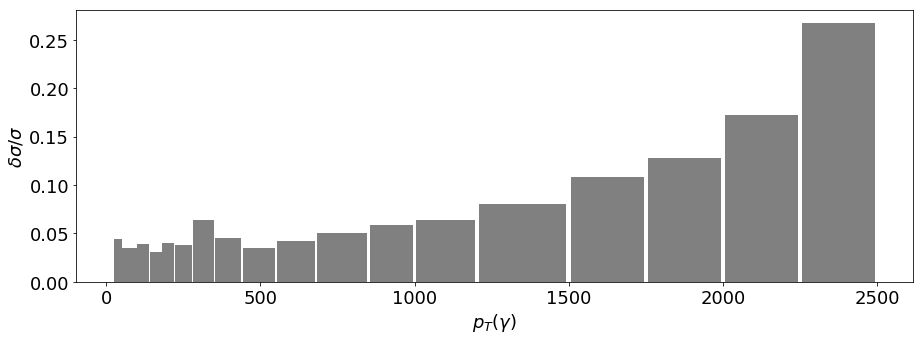

In [106]:
bins_lower = np.array([v[0] for v in pt_values.values()])
bins_higher =  np.array([v[1] for v in pt_values.values()])
bins = (bins_higher+bins_lower)/2

plt.rcParams.update({'font.size': 18})
f, ax = plt.subplots(figsize=(15,5))
plt.bar(bins, delta_pt_bin.values(), width =0.95* (bins_higher-bins_lower), color = 'gray')
plt.xlabel('$p_T(\gamma)$', fontsize=18)
plt.ylabel('$\delta \sigma / \sigma$', fontsize=18)
plt.show()